### **Data Preparing and Modeling Notebook**

**Overview:**
As a photography enthusiast, I am interested in building an photography genre image classification for landscape and portrait. This project's target is a bianry output. 0 being landscape and 1 being portrait.


**Business Problem:**
The photography classification can aid in organizing and categorizing artworks, creating thematic exhibitions, and conducting research on specific genres. It also helps organize and categorize independent photographers' own images, improve search and discovery, and gain insights into popular genres.
An accurate genre classification can enhance online photography platforms by improving search functionality, enabling better content recommendations, and enhancing user experience.

**Stakeholder:**
Curators and Art Galleries, online photography platform, and photographers.

**Data:**
10K images in total. 5000 Portrait images from Unsplash, 5000 landscape images combined from Kaggle dataset and Unsplash.






Import libraries

In [10]:
# Import analysis libraries
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns
%matplotlib inline

#Import image data
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
#from tf.keras.preprocessing import smart_resize
#from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from PIL import Image
import random
import pickle
import cv2
import os

#SKLEARN
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, recall_score

#KERAS
from keras import callbacks
from keras.utils import normalize
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

In [14]:
# import data from google drive, mount drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


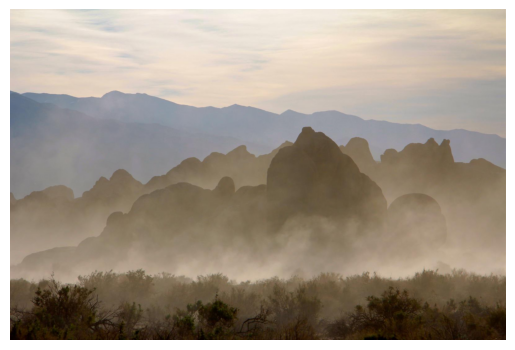

In [15]:
# check an image of landscape
image_path = '/content/drive/MyDrive/data/landscape/00000761.jpg'
image = cv2.imread(image_path)

# Convert the image from BGR to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(image_rgb)
plt.axis('off')
plt.show()




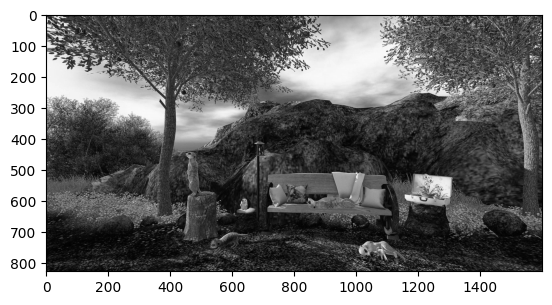

In [16]:
# Merge 2 image folders for lanscape and portrait

DATADIR = "/content/drive/MyDrive/data"
CATEGORIES = ["landscape","portrait"]

for category in CATEGORIES:
  path = os.path.join(DATADIR, category)
  for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
    plt.imshow(img_array, cmap ='gray')
    plt.show()
    break
  break


In [17]:
print(img_array)

[[ 54  41  45 ... 101  54  20]
 [  6   0   9 ...  80  15  45]
 [ 97 103 134 ...  14  79 111]
 ...
 [ 20  15   9 ...  33  48  62]
 [ 14   4   1 ...  64  61  50]
 [  2   5  19 ...  68  77  73]]


In [18]:
img_array.shape

(826, 1600)

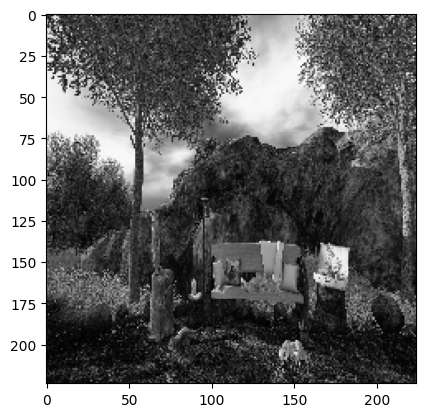

In [19]:
# change size of the image and see how it looks, revise img_size...
IMG_SIZE = 224
new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap = 'gray')
plt.show()

In [20]:
# create a entire data set with all ~5030 landscape and ~5030 portraits and reshape them to 224 x 224, grayscaled or colored?
dataset = []

def create_dataset():
  for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    class_num = CATEGORIES.index(category) # labels the data to 0 and 1, 0 for landscape, 1 for portrait
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE) # change to all grey scale
        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) # resize
        dataset.append([new_array, class_num])
      except Exception as e:
        pass

create_dataset()

In [21]:
print(len(dataset))

10060


In [22]:
# shuttle or randomize enire dataset
import random
random.shuffle(dataset)

In [23]:
for sample in dataset[:10]:
  print(sample[1])

1
1
0
0
0
0
0
0
1
0


In [24]:
# Define features and target
X = []
y = []

In [25]:
# Split dataset to X and y
for features, label in dataset:
  X.append(features)
  y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE,1) #1 is for gray scale, 3 is for colored

In [26]:
# create separate files for features and targets

pickle_out = open('X.pickle', 'wb')
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open('y.pickle', 'wb')
pickle.dump(y, pickle_out)
pickle_out.close()


In [27]:
X = pickle.load(open("X.pickle", 'rb'))
y = pickle.load(open("y.pickle", 'rb'))

In [28]:
# Normalize X of the entire dataset
X = X/255.0

In [29]:
X.shape

(10060, 224, 224, 1)

In [30]:
len(y)

10060

In [31]:
y = np.array(y)

In [32]:
# Get the unique values and their counts
unique_values, value_counts = np.unique(y, return_counts=True)

# Print the unique values and their counts
for value, count in zip(unique_values, value_counts):
    print(f"{value}: {count}")

0: 5027
1: 5033




Split the dataset to training, validation and testing

In [33]:
# 0.15 for testing, 0.15 for validation, and 0.7 for training

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.176, random_state = 42)

Start CNN modeling!

In [117]:
# Create the convolutional base
model1 = Sequential()
model1.add(Conv2D(filters=64,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape= X.shape[1:]))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

# Add Dense layers on top
model1.add(Flatten())
model1.add(Dense(64, activation='relu'))

# Add output layer
model1.add(Dense(1, activation='sigmoid'))

# Compile the model
model1.compile(optimizer = "adam",
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])
# fit the model
results1 = model1.fit(X_train, y_train, epochs = 30, batch_size = 32, validation_data = [X_val, y_val])

Epoch 1/30
221/221 [==============================] - 5s 16ms/step - loss: 0.3563 - accuracy: 0.8798 - val_loss: 0.1141 - val_accuracy: 0.9628
Epoch 2/30
221/221 [==============================] - 3s 13ms/step - loss: 0.1185 - accuracy: 0.9641 - val_loss: 0.0849 - val_accuracy: 0.9728
Epoch 3/30
221/221 [==============================] - 3s 13ms/step - loss: 0.0684 - accuracy: 0.9780 - val_loss: 0.0826 - val_accuracy: 0.9721
Epoch 4/30
221/221 [==============================] - 3s 13ms/step - loss: 0.0501 - accuracy: 0.9828 - val_loss: 0.0849 - val_accuracy: 0.9734
Epoch 5/30
221/221 [==============================] - 3s 13ms/step - loss: 0.0345 - accuracy: 0.9882 - val_loss: 0.1068 - val_accuracy: 0.9708
Epoch 6/30
221/221 [==============================] - 3s 13ms/step - loss: 0.0156 - accuracy: 0.9963 - val_loss: 0.2153 - val_accuracy: 0.9522
Epoch 7/30
221/221 [==============================] - 3s 13ms/step - loss: 0.0184 - accuracy: 0.9952 - val_loss: 0.1256 - val_accuracy: 0.9688

Visualizations for loss and accuracy comparing training and testing

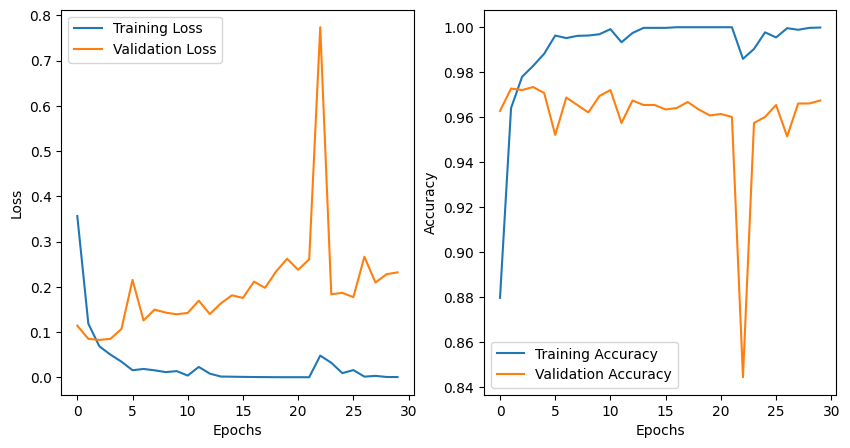

In [118]:
train_loss = results1.history['loss']
train_accuracy = results1.history['accuracy']

val_loss = results1.history['val_loss']
val_accuracy = results1.history['val_accuracy']


# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot training loss and validation loss
sns.lineplot(x=results1.epoch, y=train_loss, ax=ax1, label='Training Loss')
sns.lineplot(x=results1.epoch, y=val_loss, ax=ax1, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')


# Plot training accuracy and validation accurary
sns.lineplot(x=results1.epoch, y=train_accuracy, ax=ax2, label='Training Accuracy')
sns.lineplot(x=results1.epoch, y=val_accuracy, ax=ax2, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')

plt.show()



In [120]:
val_loss, val_acc = model1.evaluate(X_val, y_val)

48/48 [==============================] - 0s 7ms/step - loss: 0.2319 - accuracy: 0.9674


First model is extremely overfit comparing its loss and accuracy between training and validation results.

Ways to improve:
1. Use Augmentation to increase the diversity of the training data.
2. Add regularizations (L1 and L2) and dropout
3. Reduce image size
4. Add early stopping
5. Model complexity reduction: decreasing the number of layers, reducing the number of filters, or using smaller filter sizes.

### Add Augmentation




In [43]:
# add early stop
# early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, verbose=1, mode='min', patience=5) # focus on val_loss

In [136]:
# define augmentation parameters
aug1 = ImageDataGenerator(
    rotation_range=20, # rotate images randomly up to 20 degrees
    width_shift_range=0.2, #shift image horizontally by a fraction of the total width
    height_shift_range=0.2, #shift image vertically by a fraction of the total height
    brightness_range=None,
    shear_range=0.2, # apply shear transformation
    zoom_range=0.2, # zoom in / out on image
    channel_shift_range=0.0,
    fill_mode='nearest',
    horizontal_flip= True,
    vertical_flip= True
)

# Apply augmentation on training data
train_generator1 = aug1.flow(X_train, y_train, batch_size = 32)

# Use fit_generator to fit the training data with augmentation
results2 = model1.fit_generator(train_generator1,

          epochs = 30,
          validation_data = (X_val, y_val))
          # callbacks = [early_stop])

Epoch 1/30


<ipython-input-136-aafbdd16f297>:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  results2 = model1.fit_generator(train_generator1,


221/221 [==============================] - 24s 109ms/step - loss: 0.0591 - accuracy: 0.9806 - val_loss: 0.1381 - val_accuracy: 0.9548
Epoch 2/30
221/221 [==============================] - 23s 105ms/step - loss: 0.0635 - accuracy: 0.9789 - val_loss: 0.1262 - val_accuracy: 0.9548
Epoch 3/30
221/221 [==============================] - 24s 106ms/step - loss: 0.0578 - accuracy: 0.9790 - val_loss: 0.1237 - val_accuracy: 0.9575
Epoch 4/30
221/221 [==============================] - 24s 106ms/step - loss: 0.0591 - accuracy: 0.9786 - val_loss: 0.1253 - val_accuracy: 0.9608
Epoch 5/30
221/221 [==============================] - 23s 106ms/step - loss: 0.0673 - accuracy: 0.9790 - val_loss: 0.1682 - val_accuracy: 0.9449
Epoch 6/30
221/221 [==============================] - 24s 106ms/step - loss: 0.0806 - accuracy: 0.9720 - val_loss: 0.4266 - val_accuracy: 0.8944
Epoch 7/30
221/221 [==============================] - 24s 107ms/step - loss: 0.0646 - accuracy: 0.9776 - val_loss: 0.1739 - val_accuracy: 0.9

# VISUALIZATION for 30 epochs with augmentation:

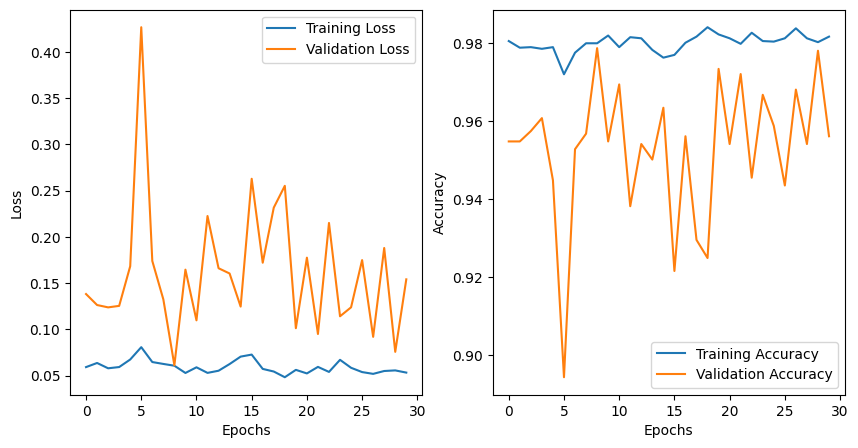

In [137]:
train_loss = results2.history['loss']
train_accuracy = results2.history['accuracy']

val_loss = results2.history['val_loss']
val_accuracy = results2.history['val_accuracy']


# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot training loss and validation loss
sns.lineplot(x=results2.epoch, y=train_loss, ax=ax1, label='Training Loss')
sns.lineplot(x=results2.epoch, y=val_loss, ax=ax1, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')


# Plot training accuracy and validation accurary
sns.lineplot(x=results2.epoch, y=train_accuracy, ax=ax2, label='Training Accuracy')
sns.lineplot(x=results2.epoch, y=val_accuracy, ax=ax2, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')

plt.show()

Do a predict on an image.

In [138]:
model1.save("augmented_model1.h5")


In [139]:
# Save the augmentation configuration
with open("augmentation_config1.pkl", "wb") as file:
    pickle.dump(aug1, file)

In [140]:
# Load the augmentation configuration
with open("augmentation_config1.pkl", "rb") as file:
    aug = pickle.load(file)

In [141]:
y_pred_prob = model1.predict(X_val)
threshold = 0.5
y_pred = (y_pred_prob > threshold).astype(int)
print(y_pred)

48/48 [==============================] - 0s 5ms/step
[[1]
 [0]
 [0]
 ...
 [1]
 [0]
 [0]]


In [142]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       738
           1       1.00      0.92      0.96       767

    accuracy                           0.96      1505
   macro avg       0.96      0.96      0.96      1505
weighted avg       0.96      0.96      0.96      1505



In [143]:
val_loss, val_acc = model1.evaluate(X_val, y_val)

48/48 [==============================] - 0s 6ms/step - loss: 0.1540 - accuracy: 0.9561



without augmentation:
loss: 4.3061e-04 - accuracy: 0.9999 - val_loss: 0.2319 - val_accuracy: 0.9674

with augmentation:
loss: 0.0531 - accuracy: 0.9817 - val_loss: 0.1540 - val_accuracy: 0.9561

Compared to 1st model with no argmentation, with argmentation, val loss improved by 0.0779




To further improve the model, we can try to tweak the numbers of layers (both convolutional layer and dense layer), also change the number of nodes per layer.

### Model 2: customize the number of convolutional layers and dense layers

In [144]:
# 3 convolutional layers, 0 dense layer
# Create the convolutional base
model2 = Sequential()
model2.add(Conv2D(filters=64,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape= X.shape[1:]))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(64, (3, 3), activation='relu')) # add one more convolutional layer
model2.add(MaxPooling2D(pool_size=(2, 2)))


# Add Dense layers on top
model2.add(Flatten())
#model2.add(Dense(64, activation='relu')) #remove dense layer

# Add output layer
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(optimizer = "adam",
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

# fit the model with augmentation and early stop
results3 = model2.fit_generator(train_generator1,
          epochs = 30,
          validation_data = (X_val, y_val))
          #callbacks = [early_stop])

Epoch 1/30


<ipython-input-144-0874b85bd5cc>:30: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  results3 = model2.fit_generator(train_generator1,


221/221 [==============================] - 26s 108ms/step - loss: 0.3589 - accuracy: 0.8335 - val_loss: 0.3281 - val_accuracy: 0.9063
Epoch 2/30
221/221 [==============================] - 24s 106ms/step - loss: 0.2113 - accuracy: 0.9319 - val_loss: 0.2886 - val_accuracy: 0.9262
Epoch 3/30
221/221 [==============================] - 23s 105ms/step - loss: 0.1817 - accuracy: 0.9441 - val_loss: 0.1982 - val_accuracy: 0.9435
Epoch 4/30
221/221 [==============================] - 23s 106ms/step - loss: 0.1792 - accuracy: 0.9418 - val_loss: 0.2278 - val_accuracy: 0.9449
Epoch 5/30
221/221 [==============================] - 23s 106ms/step - loss: 0.1640 - accuracy: 0.9478 - val_loss: 0.1366 - val_accuracy: 0.9654
Epoch 6/30
221/221 [==============================] - 23s 106ms/step - loss: 0.1625 - accuracy: 0.9493 - val_loss: 0.3170 - val_accuracy: 0.9269
Epoch 7/30
221/221 [==============================] - 24s 107ms/step - loss: 0.1535 - accuracy: 0.9532 - val_loss: 0.4236 - val_accuracy: 0.9

In [146]:
val_loss, val_acc = model2.evaluate(X_val, y_val)

48/48 [==============================] - 0s 7ms/step - loss: 0.0812 - accuracy: 0.9774


Visualization of loss and accuracy

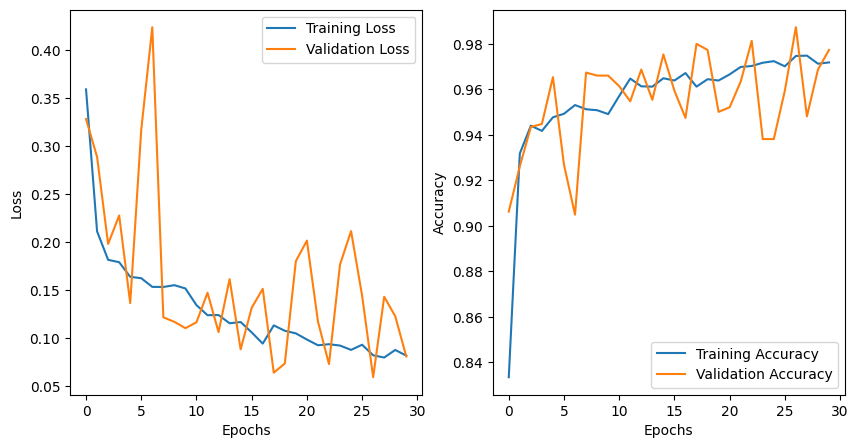

In [147]:
train_loss = results3.history['loss']
train_accuracy = results3.history['accuracy']

val_loss = results3.history['val_loss']
val_accuracy = results3.history['val_accuracy']


# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot training loss and validation loss
sns.lineplot(x=results3.epoch, y=train_loss, ax=ax1, label='Training Loss')
sns.lineplot(x=results3.epoch, y=val_loss, ax=ax1, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')


# Plot training accuracy and validation accurary
sns.lineplot(x=results3.epoch, y=train_accuracy, ax=ax2, label='Training Accuracy')
sns.lineplot(x=results3.epoch, y=val_accuracy, ax=ax2, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')

plt.show()

Model 2 improves a lot **with 3 convolutional layers and 0 dense layer while keeping the the augmentation** constant.
Comparing this model with model 1 with augmentation:

loss: 0.0531 - accuracy: 0.9817 - val_loss: 0.1540 - val_accuracy: 0.9561

loss: 0.0820 - accuracy: 0.9719 - val_loss: 0.0812 - val_accuracy: 0.9774

Both val loss and accuracy have improved greatly. also reduced overfitting!